In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt

np.warnings = warnings

ROOT_DIR = Path('..')
sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
sys.path.append(os.path.abspath(os.path.join('..')))
# import DataLoader as DataLoader
# reload(DataLoader)

# dataLoader = DataLoader.DataLoader(ROOT_DIR)

import model_evaluation as me
reload(me)

# import src.modelling_pipeline as modelling_pipeline
# reload(modelling_pipeline)

# mp = modelling_pipeline.ModelPipeline(ROOT_DIR)

<module 'model_evaluation' from 'd:\\Kha\\UWA\\CITS5553\\sepsis_prediction\\data-science-capstone-project\\Kha Huynh\\Data cleansing\\model_evaluation.py'>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

import tensorflow as tf

# Data Preparation - Train val test split

In [3]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t4_nan.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                admission['IS_SEPSIS'],
                                                test_size=0.2,
                                                )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [5]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))

In [6]:
def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    mask = tf.math.is_finite(secs_data.values)
    mask = tf.RaggedTensor.from_row_lengths(mask, X_count)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels, mask


In [7]:
def data_preparation():
  train_data, act_train, mask_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test, mask_test = ts_to_secs(x_test, x_test_count, y_test_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())

  return train_data, act_train, test_data, act_test

In [8]:
x_train, y_train, x_test, y_test = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([36972    13    43], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9244   13   43], shape=(3,), dtype=int64)


# Model Definition

In [9]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

# sample_weights = mask_train
sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

# sample_weights_test = mask_test
sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [10]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

m_hist = []
models = []

# Simple LSTM

In [11]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(128))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [13]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(256))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [14]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [15]:
from sklearn.model_selection import StratifiedKFold
k = 5
fold_size = x_train.shape[0] // k
num_epochs = 40

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for i, model in enumerate(models):
  print(f"----------------Start model {i}---------------------")

  checkpointer = ModelCheckpoint(filepath = f'weights_best_struct_gru1_{i}.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
  callbacks_list = [lr_scheduler, early_stop, checkpointer]
  model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)
  acc, val_acc, auc, val_auc, loss, val_loss= [], [], [], [], [], []
  # Loop through the k folds
  for j, (train_index, val_index) in enumerate(skf.split(x_train, y_train.argmax(1))):
    print(f'---------------------Start K={j}-------------------------------')

    x_train_kf, x_val_kf = tf.gather(x_train, train_index), tf.gather(x_train, val_index)
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

    sample_weights = me.compute_sample_weights(y_train_kf[:,1].astype(int))

    # Train the model
    m = model.fit(x_train_kf,y_train_kf,
              sample_weight=sample_weights,
              epochs=num_epochs, batch_size=64, verbose=1,
              validation_data=(x_val_kf, y_val_kf),
              callbacks=callbacks_list)
    m_hist.append(m)

----------------Start model 0---------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               66432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 66690 (260.51 KB)
Trainable params: 66690 (260.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
---------------------Start K=0-------------------------------
Epoch 1/40
463/463 [==============================] - 5s 8ms/step - loss: 0.5608 - accuracy: 0.6974 - auc: 0.7562 - val_loss: 0.5241 - val_accuracy: 0.7567 - val_auc: 0.

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 8ms/step - loss: 0.5107 - accuracy: 0.7593 - auc: 0.8218 - val_loss: 0.5202 - val_accuracy: 0.7614 - val_auc: 0.8237 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 7ms/step - loss: 0.4976 - accuracy: 0.7688 - auc: 0.8350 - val_loss: 0.5001 - val_accuracy: 0.7692 - val_auc: 0.8368 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 6s 14ms/step - loss: 0.4873 - accuracy: 0.7750 - auc: 0.8435 - val_loss: 0.4904 - val_accuracy: 0.7785 - val_auc: 0.8447 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 7s 14ms/step - loss: 0.4778 - accuracy: 0.7767 - auc: 0.8479 - val_loss: 0.4951 - val_accuracy: 0.7734 - val_auc: 0.8408 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 6s 13ms/step - loss: 0.4698 - accuracy: 0.7826 - auc: 0.8543 - val_loss: 0.4799 - val_accuracy: 0.7818 - val_auc: 0.8521 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] -

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 5s 10ms/step - loss: 0.4170 - accuracy: 0.8136 - auc: 0.8883 - val_loss: 0.4020 - val_accuracy: 0.8257 - val_auc: 0.8996 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4055 - accuracy: 0.8187 - auc: 0.8941 - val_loss: 0.4271 - val_accuracy: 0.8096 - val_auc: 0.8853 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3946 - accuracy: 0.8220 - auc: 0.8984 - val_loss: 0.4079 - val_accuracy: 0.8175 - val_auc: 0.8954 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9ms/step - loss: 0.3880 - accuracy: 0.8308 - auc: 0.9051 - val_loss: 0.4063 - val_accuracy: 0.8208 - val_auc: 0.8972 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3742 - accuracy: 0.8394 - auc: 0.9124 - val_loss: 0.3959 - val_accuracy: 0.8295 - val_auc: 0.9031 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] 

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 5s 10ms/step - loss: 0.3865 - accuracy: 0.8250 - auc: 0.9027 - val_loss: 0.3701 - val_accuracy: 0.8378 - val_auc: 0.9151 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 9ms/step - loss: 0.3737 - accuracy: 0.8335 - auc: 0.9102 - val_loss: 0.3579 - val_accuracy: 0.8427 - val_auc: 0.9204 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3604 - accuracy: 0.8427 - auc: 0.9185 - val_loss: 0.3740 - val_accuracy: 0.8348 - val_auc: 0.9126 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3479 - accuracy: 0.8472 - auc: 0.9228 - val_loss: 0.3814 - val_accuracy: 0.8300 - val_auc: 0.9097 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 11ms/step - loss: 0.3362 - accuracy: 0.8518 - auc: 0.9270 - val_loss: 0.3609 - val_accuracy: 0.8418 - val_auc: 0.9196 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] 

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 5s 11ms/step - loss: 0.3155 - accuracy: 0.8650 - auc: 0.9391 - val_loss: 0.3078 - val_accuracy: 0.8747 - val_auc: 0.9421 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3016 - accuracy: 0.8739 - auc: 0.9446 - val_loss: 0.3461 - val_accuracy: 0.8533 - val_auc: 0.9269 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.2914 - accuracy: 0.8772 - auc: 0.9489 - val_loss: 0.3166 - val_accuracy: 0.8723 - val_auc: 0.9392 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 11ms/step - loss: 0.2766 - accuracy: 0.8871 - auc: 0.9541 - val_loss: 0.2890 - val_accuracy: 0.8838 - val_auc: 0.9497 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 11ms/step - loss: 0.2684 - accuracy: 0.8904 - auc: 0.9570 - val_loss: 0.3067 - val_accuracy: 0.8747 - val_auc: 0.9433 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 5s 10ms/step - loss: 0.2692 - accuracy: 0.8871 - auc: 0.9555 - val_loss: 0.2469 - val_accuracy: 0.9025 - val_auc: 0.9643 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 5s 10ms/step - loss: 0.2602 - accuracy: 0.8932 - auc: 0.9595 - val_loss: 0.2535 - val_accuracy: 0.8963 - val_auc: 0.9623 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 11ms/step - loss: 0.2515 - accuracy: 0.8999 - auc: 0.9632 - val_loss: 0.2363 - val_accuracy: 0.9044 - val_auc: 0.9677 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 10ms/step - loss: 0.2421 - accuracy: 0.9014 - auc: 0.9652 - val_loss: 0.2325 - val_accuracy: 0.9091 - val_auc: 0.9682 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 5s 10ms/step - loss: 0.2351 - accuracy: 0.9045 - auc: 0.9677 - val_loss: 0.2410 - val_accuracy: 0.9041 - val_auc: 0.9653 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================]

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 7s 15ms/step - loss: 0.5107 - accuracy: 0.7612 - auc: 0.8228 - val_loss: 0.4913 - val_accuracy: 0.7824 - val_auc: 0.8449 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 7s 14ms/step - loss: 0.4969 - accuracy: 0.7662 - auc: 0.8355 - val_loss: 0.5371 - val_accuracy: 0.7430 - val_auc: 0.8072 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 7s 14ms/step - loss: 0.4828 - accuracy: 0.7720 - auc: 0.8424 - val_loss: 0.4737 - val_accuracy: 0.7880 - val_auc: 0.8565 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 7s 15ms/step - loss: 0.4735 - accuracy: 0.7813 - auc: 0.8531 - val_loss: 0.4909 - val_accuracy: 0.7683 - val_auc: 0.8428 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 7s 14ms/step - loss: 0.4614 - accuracy: 0.7837 - auc: 0.8609 - val_loss: 0.4503 - val_accuracy: 0.7974 - val_auc: 0.8712 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================]

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 10s 21ms/step - loss: 0.3829 - accuracy: 0.8330 - auc: 0.9077 - val_loss: 0.3822 - val_accuracy: 0.8324 - val_auc: 0.9091 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 10s 21ms/step - loss: 0.3683 - accuracy: 0.8405 - auc: 0.9150 - val_loss: 0.3562 - val_accuracy: 0.8465 - val_auc: 0.9212 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 9s 19ms/step - loss: 0.3488 - accuracy: 0.8497 - auc: 0.9239 - val_loss: 0.3553 - val_accuracy: 0.8498 - val_auc: 0.9225 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 9s 20ms/step - loss: 0.3325 - accuracy: 0.8591 - auc: 0.9313 - val_loss: 0.3612 - val_accuracy: 0.8473 - val_auc: 0.9201 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 8s 17ms/step - loss: 0.3197 - accuracy: 0.8667 - auc: 0.9373 - val_loss: 0.3996 - val_accuracy: 0.8318 - val_auc: 0.9033 - lr: 5.4881e-04
Epoch 8/40
463/463 [=============================

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 9s 20ms/step - loss: 0.3093 - accuracy: 0.8713 - auc: 0.9424 - val_loss: 0.2889 - val_accuracy: 0.8837 - val_auc: 0.9499 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 10s 22ms/step - loss: 0.2779 - accuracy: 0.8848 - auc: 0.9528 - val_loss: 0.2685 - val_accuracy: 0.8953 - val_auc: 0.9564 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 11s 23ms/step - loss: 0.2617 - accuracy: 0.8940 - auc: 0.9594 - val_loss: 0.2543 - val_accuracy: 0.8976 - val_auc: 0.9612 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 10s 22ms/step - loss: 0.2423 - accuracy: 0.9003 - auc: 0.9651 - val_loss: 0.2455 - val_accuracy: 0.9042 - val_auc: 0.9636 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 11s 24ms/step - loss: 0.2359 - accuracy: 0.9066 - auc: 0.9679 - val_loss: 0.2802 - val_accuracy: 0.8858 - val_auc: 0.9522 - lr: 6.0653e-04
Epoch 7/40
463/463 [===========================

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 11s 23ms/step - loss: 0.2210 - accuracy: 0.9121 - auc: 0.9728 - val_loss: 0.2163 - val_accuracy: 0.9182 - val_auc: 0.9730 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 11s 23ms/step - loss: 0.2125 - accuracy: 0.9159 - auc: 0.9735 - val_loss: 0.1863 - val_accuracy: 0.9324 - val_auc: 0.9807 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 11s 24ms/step - loss: 0.2008 - accuracy: 0.9240 - auc: 0.9784 - val_loss: 0.2034 - val_accuracy: 0.9257 - val_auc: 0.9764 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 11s 23ms/step - loss: 0.1932 - accuracy: 0.9245 - auc: 0.9790 - val_loss: 0.1819 - val_accuracy: 0.9325 - val_auc: 0.9809 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 11s 23ms/step - loss: 0.1807 - accuracy: 0.9310 - auc: 0.9824 - val_loss: 0.1971 - val_accuracy: 0.9276 - val_auc: 0.9770 - lr: 5.4881e-04
Epoch 8/40
463/463 [==========================

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 8s 18ms/step - loss: 0.1726 - accuracy: 0.9343 - auc: 0.9840 - val_loss: 0.1616 - val_accuracy: 0.9401 - val_auc: 0.9855 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 8s 17ms/step - loss: 0.1664 - accuracy: 0.9378 - auc: 0.9853 - val_loss: 0.1636 - val_accuracy: 0.9381 - val_auc: 0.9847 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 7s 15ms/step - loss: 0.1616 - accuracy: 0.9359 - auc: 0.9853 - val_loss: 0.1709 - val_accuracy: 0.9339 - val_auc: 0.9827 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 8s 16ms/step - loss: 0.1597 - accuracy: 0.9385 - auc: 0.9860 - val_loss: 0.1593 - val_accuracy: 0.9389 - val_auc: 0.9848 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 8s 16ms/step - loss: 0.1542 - accuracy: 0.9414 - auc: 0.9871 - val_loss: 0.1687 - val_accuracy: 0.9343 - val_auc: 0.9830 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 7ms/step - loss: 0.5161 - accuracy: 0.7544 - auc: 0.8132 - val_loss: 0.5256 - val_accuracy: 0.7598 - val_auc: 0.8200 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 3s 7ms/step - loss: 0.5030 - accuracy: 0.7688 - auc: 0.8308 - val_loss: 0.5063 - val_accuracy: 0.7683 - val_auc: 0.8335 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4929 - accuracy: 0.7698 - auc: 0.8365 - val_loss: 0.5121 - val_accuracy: 0.7616 - val_auc: 0.8292 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4840 - accuracy: 0.7752 - auc: 0.8430 - val_loss: 0.4756 - val_accuracy: 0.7838 - val_auc: 0.8553 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4792 - accuracy: 0.7795 - auc: 0.8505 - val_loss: 0.4977 - val_accuracy: 0.7715 - val_auc: 0.8403 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 3s

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 7ms/step - loss: 0.4387 - accuracy: 0.8041 - auc: 0.8779 - val_loss: 0.4639 - val_accuracy: 0.7855 - val_auc: 0.8624 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 7ms/step - loss: 0.4295 - accuracy: 0.8082 - auc: 0.8807 - val_loss: 0.4530 - val_accuracy: 0.7955 - val_auc: 0.8694 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 7ms/step - loss: 0.4232 - accuracy: 0.8128 - auc: 0.8854 - val_loss: 0.4180 - val_accuracy: 0.8121 - val_auc: 0.8901 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4145 - accuracy: 0.8129 - auc: 0.8887 - val_loss: 0.4198 - val_accuracy: 0.8111 - val_auc: 0.8895 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4112 - accuracy: 0.8178 - auc: 0.8910 - val_loss: 0.4266 - val_accuracy: 0.8101 - val_auc: 0.8862 - lr: 4.9659e-04
---------------------Start K=2--------------------------

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 7ms/step - loss: 0.4205 - accuracy: 0.8072 - auc: 0.8840 - val_loss: 0.4062 - val_accuracy: 0.8193 - val_auc: 0.8965 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 7ms/step - loss: 0.4112 - accuracy: 0.8167 - auc: 0.8941 - val_loss: 0.4415 - val_accuracy: 0.8029 - val_auc: 0.8767 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4048 - accuracy: 0.8193 - auc: 0.8940 - val_loss: 0.4336 - val_accuracy: 0.8061 - val_auc: 0.8812 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4s 7ms/step - loss: 0.4013 - accuracy: 0.8208 - auc: 0.8974 - val_loss: 0.4178 - val_accuracy: 0.8148 - val_auc: 0.8904 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 4s 7ms/step - loss: 0.3909 - accuracy: 0.8245 - auc: 0.9026 - val_loss: 0.4202 - val_accuracy: 0.8173 - val_auc: 0.8902 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 4s

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 3s 7ms/step - loss: 0.4229 - accuracy: 0.8091 - auc: 0.8853 - val_loss: 0.4072 - val_accuracy: 0.8226 - val_auc: 0.8963 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4114 - accuracy: 0.8153 - auc: 0.8899 - val_loss: 0.3929 - val_accuracy: 0.8267 - val_auc: 0.9038 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4027 - accuracy: 0.8183 - auc: 0.8946 - val_loss: 0.3935 - val_accuracy: 0.8268 - val_auc: 0.9033 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3970 - accuracy: 0.8204 - auc: 0.8988 - val_loss: 0.4050 - val_accuracy: 0.8228 - val_auc: 0.8972 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3879 - accuracy: 0.8279 - auc: 0.9039 - val_loss: 0.3971 - val_accuracy: 0.8240 - val_auc: 0.9016 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 3s

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 3s 7ms/step - loss: 0.3866 - accuracy: 0.8260 - auc: 0.9023 - val_loss: 0.3884 - val_accuracy: 0.8279 - val_auc: 0.9059 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 7ms/step - loss: 0.3799 - accuracy: 0.8314 - auc: 0.9070 - val_loss: 0.3863 - val_accuracy: 0.8293 - val_auc: 0.9067 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3728 - accuracy: 0.8370 - auc: 0.9120 - val_loss: 0.3825 - val_accuracy: 0.8332 - val_auc: 0.9091 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3698 - accuracy: 0.8370 - auc: 0.9122 - val_loss: 0.3863 - val_accuracy: 0.8319 - val_auc: 0.9068 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3591 - accuracy: 0.8439 - auc: 0.9178 - val_loss: 0.3887 - val_accuracy: 0.8333 - val_auc: 0.9065 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 3s

In [16]:
reload(me)

chart_types = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'loss', 'val_loss']
mean_history = me.cal_model_mean(m_hist, k, chart_types)

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\Kha Huynh\Data cleansing\model_evaluation.py:199: RuntimeWarning: Mean of empty slice
  mean_measure = np.nanmean(hist_list, axis=0)
d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


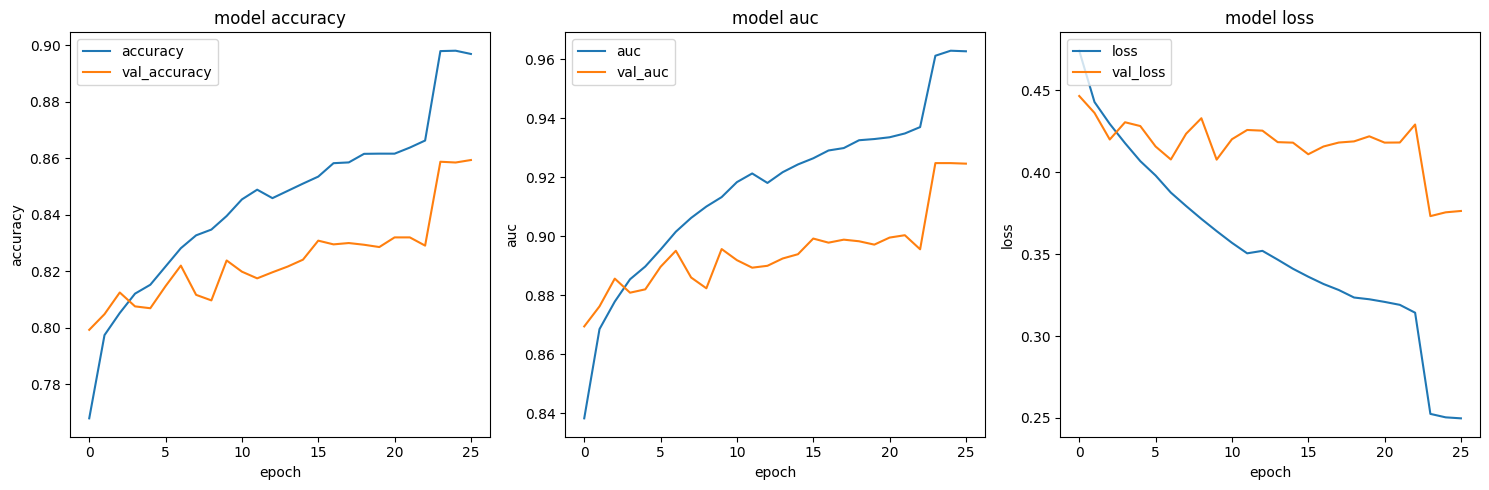

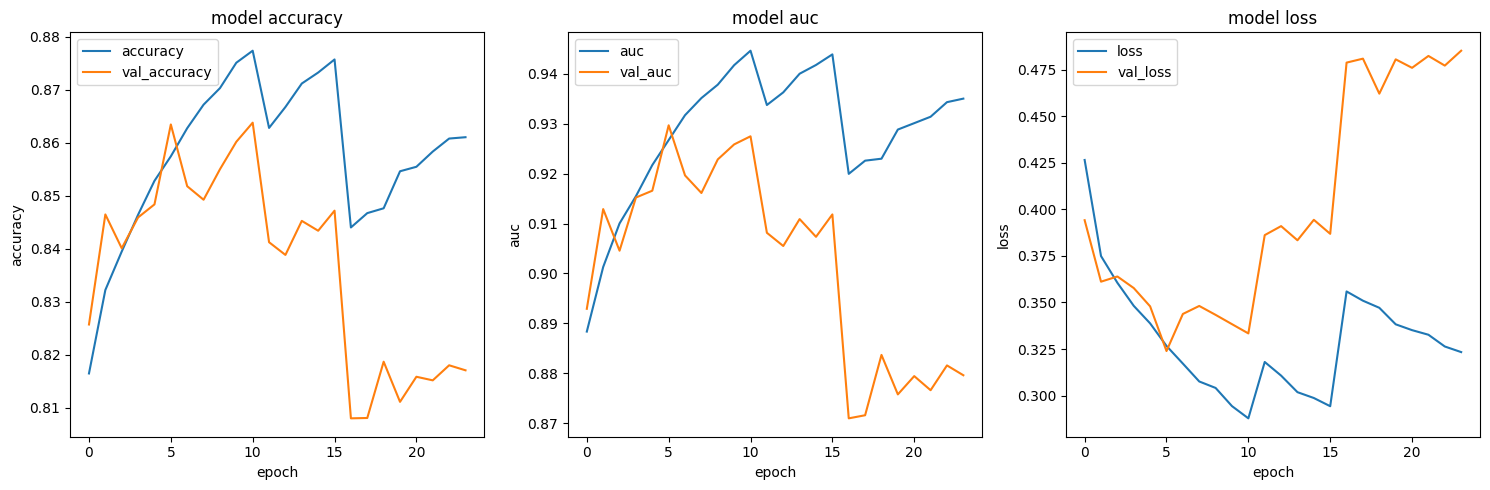

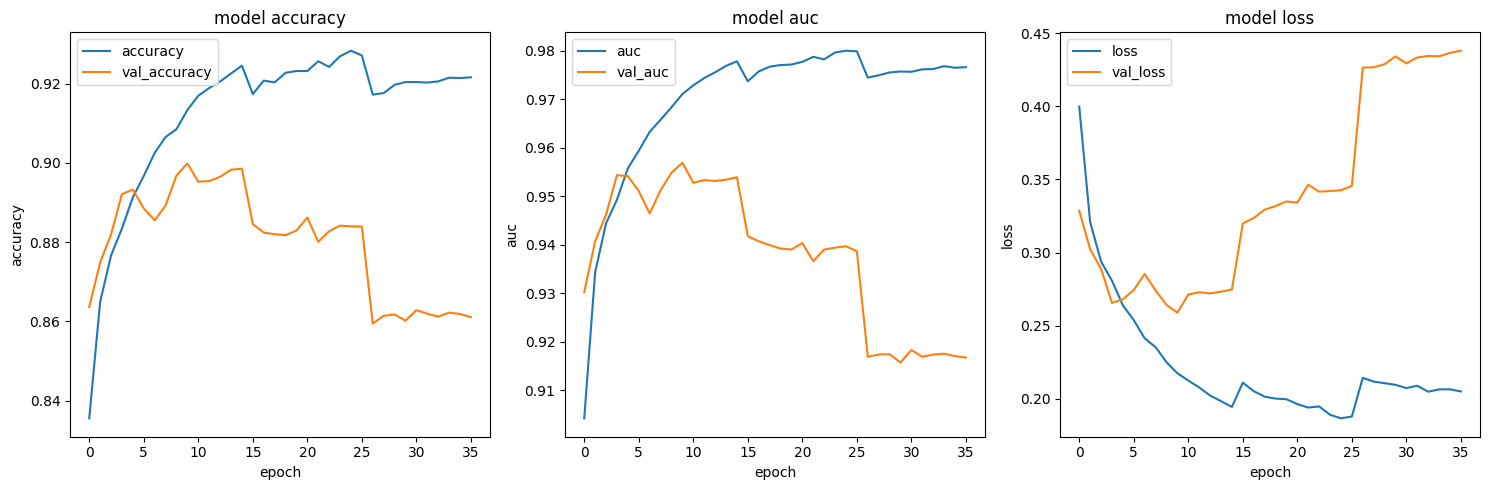

In [17]:
import matplotlib.pyplot as plt

for i, _ in enumerate(mean_history):
  # Create a figure with two subplots side by side
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

  # plt.plot(m.history['loss'])
  plt1.plot(mean_history[i][0])
  plt1.plot(mean_history[i][1])
  plt1.set_title('model accuracy')
  plt1.set_ylabel('accuracy')
  plt1.set_xlabel('epoch')
  plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt2.plot(mean_history[i][2])
  plt2.plot(mean_history[i][3])
  plt2.set_title('model auc')
  plt2.set_ylabel('auc')
  plt2.set_xlabel('epoch')
  plt2.legend(['auc', 'val_auc'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt3.plot(mean_history[i][4])
  plt3.plot(mean_history[i][5])
  plt3.set_title('model loss')
  plt3.set_ylabel('loss')
  plt3.set_xlabel('epoch')
  plt3.legend(['loss', 'val_loss'], loc='upper left')

  plt.tight_layout()
  plt.show()

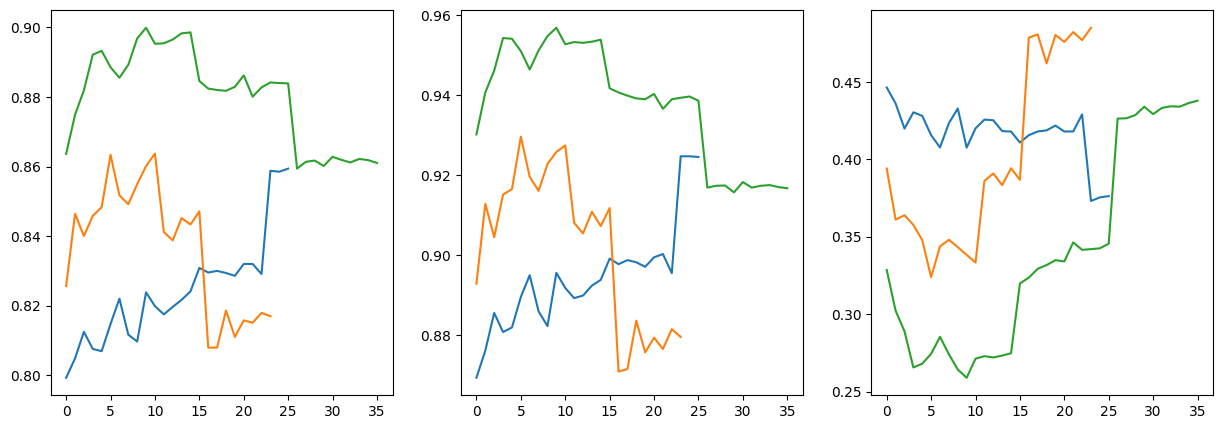

In [18]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
plts = [plt1, plt2, plt3]

for i, chart in enumerate(range(0, 5, 2)):
  plts[i].plot(mean_history[0][chart+1])
  plts[i].plot(mean_history[1][chart+1])
  plts[i].plot(mean_history[2][chart+1])
  # plts[i].legend([f"lstm softmax val_acc", f"lstm sigmoid val_auc", f"gru softmax val_loss", f"gru sigmoid {chart_type}"], loc="lower right")

Inference:
Inference:
Inference:
289/289 [==============================] - 0s 1ms/step


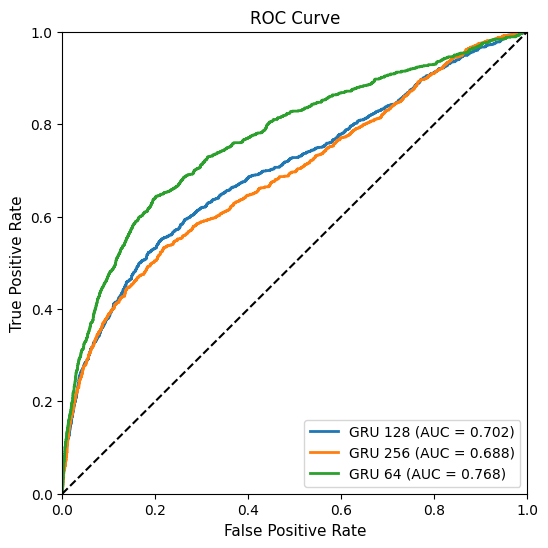

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,GRU 128,0.908532,0.656900,0.587399,0.286817,0.892687,0.448241,0.708558,0.349804
1,GRU 256,0.939023,0.645284,0.720747,0.304580,0.921086,0.401005,0.808694,0.346204
2,GRU 64,0.844954,0.714819,0.419885,0.305498,0.827846,0.591960,0.557172,0.403011


In [20]:
from keras.models import load_model
reload(me)

trained_models = {}
model_names = ['GRU 128', 'GRU 256', 'GRU 64']
for i, m in enumerate(model_names):
  print("Inference:")
  model = load_model(f"weights_best_struct_gru1_{i}.hdf5")
  model.optimizer.lr.numpy()
  trained_models[m] = model

me.plot_combined_roc_curves(trained_models, x_train, y_train, x_test, y_test)
# me.print_results(model, x_train, y_train, x_test, y_test)